In [607]:
import networkx as nx
from networkx.algorithms import community as nxcomm
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from node2vec import Node2Vec
import community
from networkx.algorithms.community.centrality import girvan_newman
import community as community_louvain
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from networkx.algorithms.link_analysis.pagerank_alg import pagerank as pagerank
from sklearn.cluster import KMeans
from sklearn import cluster as clu
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
%matplotlib inline

In [2]:
#import the edges dataset
de_edgelist = pd.read_csv('C:\\Users\\ali.arslan\\Desktop\\Sabancı Data Analytics\\DA_516\\Project\\DE\\DE_edges.csv', header=0)
edgelist = pd.concat([de_edgelist], axis=0)
edgelist.columns = ['source', 'target']
edgelist.head()

,source,target
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275


In [3]:
#import the node features dataset
de_features = pd.read_csv('C:\\Users\\ali.arslan\\Desktop\\Sabancı Data Analytics\\DA_516\\Project\\DE\\DE_target.csv', header=0, usecols=["new_id", "partner", "views", "mature", "days"])
de_features["Lang"] = "DE"

featurelist = pd.concat([de_features], axis=0)
featurelist = pd.get_dummies(featurelist, columns=["mature", "partner"])
featurelist.head()

,days,views,new_id,Lang,mature_False,mature_True,partner_False,partner_True
0,2149,162078,5079,DE,0,1,1,0
1,1574,1370,4281,DE,0,1,1,0
2,1034,6043,992,DE,0,1,1,0
3,1319,94298,9021,DE,0,1,0,1
4,2137,2323,330,DE,0,1,1,0


In [680]:
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr=None, create_using=nx.Graph())
print("Info:\n", nx.info(G), "\n")
print("Is directed: ", nx.is_directed(G))
#print("Average Shortest Path Length(G): ", nx.average_shortest_path_length(G))
#print("\n")
#print("Diameter(G): ", nx.diameter(G))

Info:
 Name: 
Type: Graph
Number of nodes: 9498
Number of edges: 153138
Average degree:  32.2464 

Is directed:  False


In [5]:
edgelist["flag"] = 1
edgelist["source"] = edgelist["source"].astype("str")
edgelist["target"] = edgelist["target"].astype("str")
edgelist.shape

(153138, 3)

In [30]:
edgelist.head()

,source,target,flag
0,0,9206,1
1,0,7787,1
2,0,2145,1
3,0,2684,1
4,0,7275,1


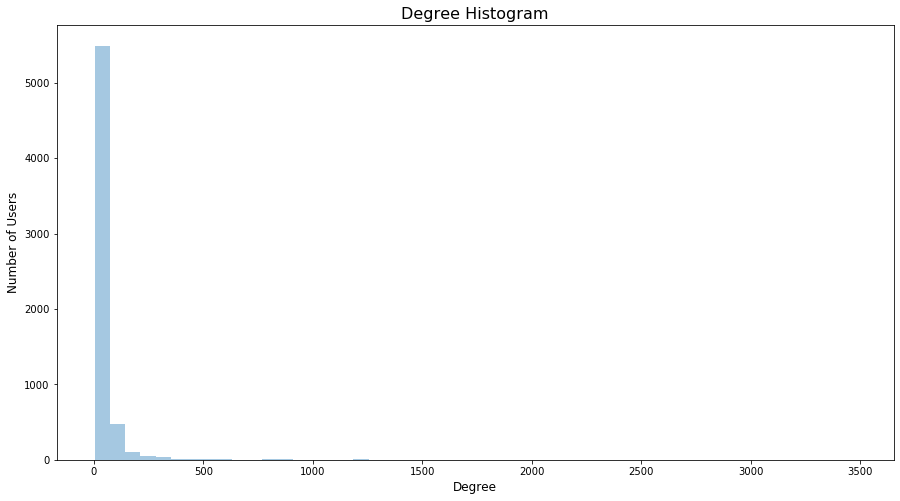

In [619]:
degree_sequence = sorted([d for n, d in G_filtered.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)

deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(15, 8))
plt.title("Degree Histogram", fontsize=16)
plt.ylabel("Number of Users", fontsize=12)
plt.xlabel("Degree", fontsize=12)

sns.distplot(degree_sequence, kde=False)
plt.show()

In [460]:
degree_dict = dict(G.degree)
selected_nodes = []
for i in degree_dict:
    if degree_dict[i] >= 10:
        selected_nodes.append(str(i))
        
edgelist_filtered = edgelist[edgelist["source"].isin(selected_nodes)]
edgelist_filtered = edgelist_filtered[edgelist_filtered["target"].isin(selected_nodes)]


In [459]:
G_filtered = nx.from_pandas_edgelist(edgelist_filtered, source='source', target='target', edge_attr=None, create_using=nx.Graph())
print("Info:\n", nx.info(G_filtered), "\n")
print("Is directed: ", nx.is_directed(G_filtered))

Info:
 Name: 
Type: Graph
Number of nodes: 6216
Number of edges: 138791
Average degree:  44.6560 

Is directed:  False


In [ ]:
dgc = nx.degree_centrality(G_filtered)
eig = nx.eigenvector_centrality(G_filtered)
pgr = nx.pagerank(G_filtered)


cr = pd.DataFrame(index=G_filtered.nodes())
cr['dgc'] = cr.index.map(dgc)
cr['eig'] = cr.index.map(eig)
cr['pgr'] = cr.index.map(pgr)
cr.sort_values(by='pgr', ascending=False)


In [461]:
nx.set_node_attributes(G, degree_dict, 'degree')

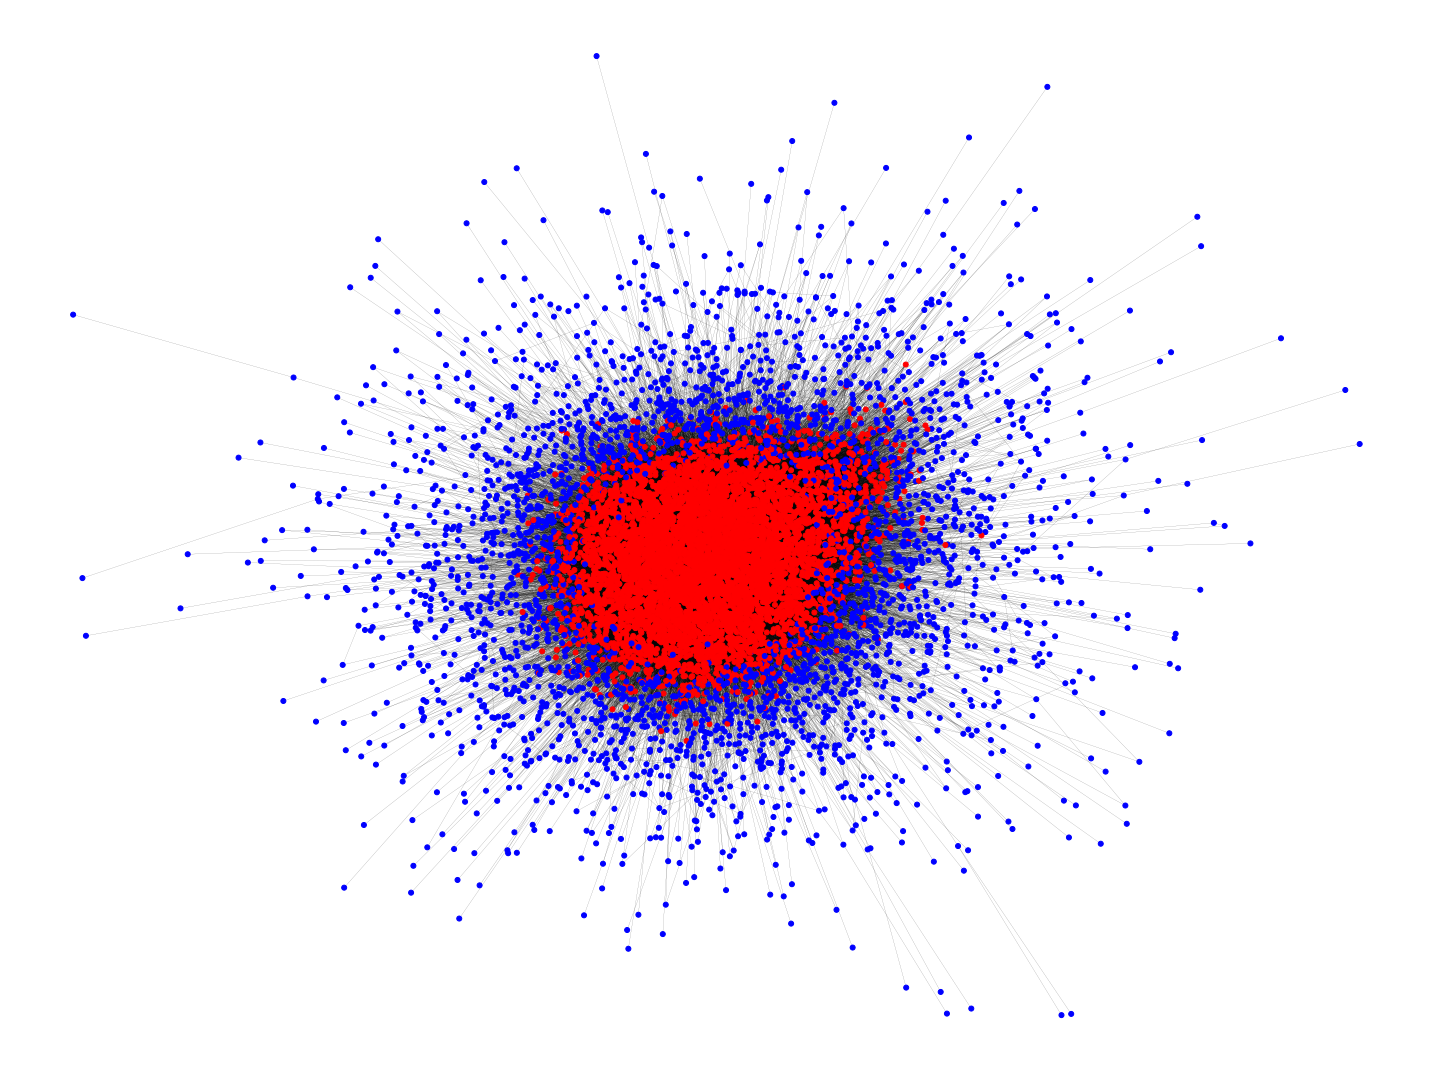

In [495]:
pos = nx.spring_layout(G, seed = 42) 
plt.figure(figsize=(20, 15))
# nodes
nx.draw_networkx_nodes(G, pos, node_color=["red" if G.nodes[n]['degree'] >= 10 else "blue" for n in G.nodes], node_size=25)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.1)
# labels
#nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif", )

plt.axis("off")
plt.tight_layout()
plt.show()


**Community Detection**

In [605]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def visualize(g, partition_g, color_choice="auto", width=1):
    if color_choice == "auto":
        pos = community_layout(g, partition_g)
        plt.figure(figsize=(20, 15))
        nx.draw(g, pos, node_color=list(partition_g.values()), node_size=15, width=list(pgrdf["pgr"].values)); plt.show()
        return
    if color_choice == "manuel":
        pos = community_layout(g, partition_g)
        plt.figure(figsize=(20, 15))
        nx.draw(g, pos, node_color=centrality_colors, node_size=15, width=list(dict(G_filtered.degree).values())); plt.show()
        return    

In [462]:
#compute the best partition
partition = community_louvain.best_partition(G_filtered, weight="None", random_state=42)

In [465]:
print("Modularity of the calculated communities\n")
print(community.modularity(partition, G_filtered))

Modularity of the calculated communities

0.27870681842926565


In [508]:
pgr = pagerank(G_filtered, weight=None)

In [577]:
partitiondf = pd.DataFrame(partition, index=[0]).T.reset_index().rename(columns={"index":"node", 0:"class"})
pgrdf = pd.DataFrame(pgr, index=[0]).T.reset_index().rename(columns={"index":"node", 0:"pgr"})
pgr_partition = pd.merge(partitiondf, pgrdf, how='inner')
leader_centralities = pgr_partition.groupby("class")["pgr"].max().values

community_leaders = []
for i in range(len(leader_centralities)):
    community_leaders.append(pgr_partition[pgr_partition["class"] == i].sort_values("pgr", ascending=False).iloc[0:1,0:1].values[0][0])
    
centrality_colors = []
for node in G_filtered.nodes:
    if node in community_leaders:
        color = "red"
        centrality_colors.append(color)
    if node not in community_leaders: 
        if pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 0:
            color = "skyblue"
        elif pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 1:
            color = "purple"
        elif pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 2:
            color = "yellow"
        elif pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 3:
            color = "lightgreen"      
        elif pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 4:
            color = "darkblue"  
        elif pgr_partition[pgr_partition["node"] == str(node)]["class"].values[0] == 5:
            color = "orange"                  
        centrality_colors.append(color)    

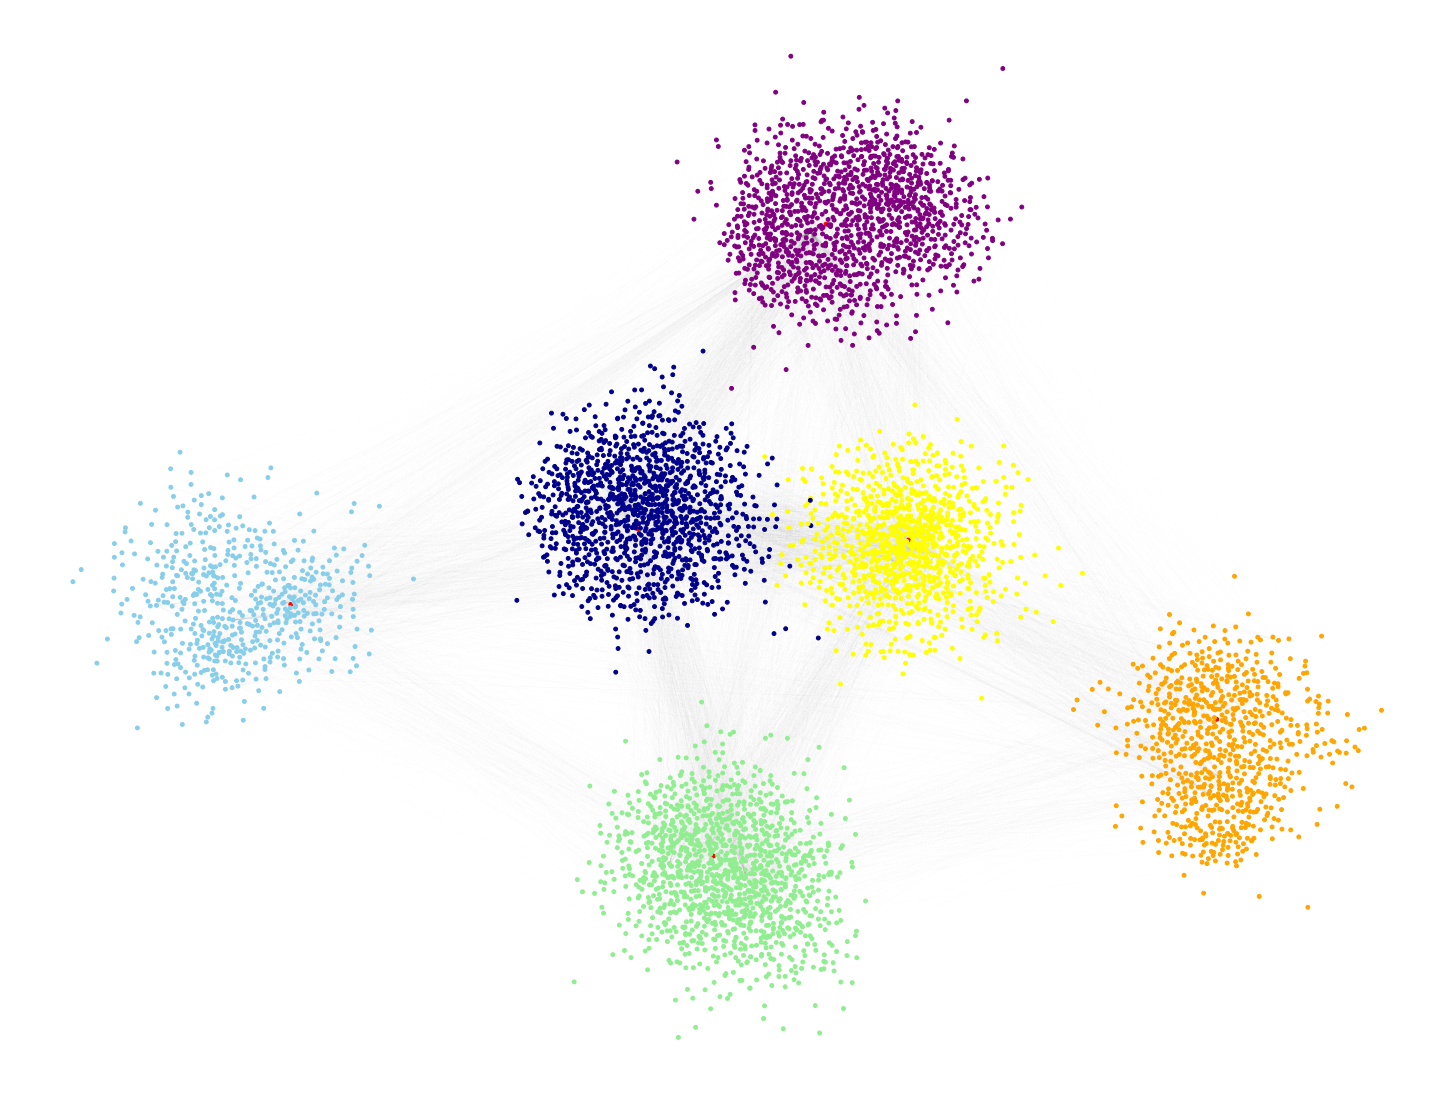

In [596]:
visualize(G_filtered, partition, color_choice="manuel")

In [663]:
print("Number of Communities:",len(set(partition.values())))

Number of Communities: 6


In [500]:
gn_comms =nxcomm.kernighan_lin_bisection(G_filtered, weight=None)
print("Modularity of the calculated communities with Kernighan–Lin bipartition algorithm\n")
print(nxcomm.quality.modularity(G_filtered, communities=gn_comms))

Modularity of the calculated communities with Kernighan–Lin bipartition algorithm

0.003062088671440061


**Node Classification**

In [471]:
print(len(G_filtered.nodes)**(1/2))
print(len(G_filtered.nodes)**(1/3))

78.8416133777081
18.386694855142967


In [472]:
n2v = Node2Vec(G_filtered, dimensions=20, walk_length=20, num_walks=50, p = 1, q = 1, weight_key = None, workers=4) 
model = n2v.fit(window=10)

In [473]:
model.wv.save_word2vec_format('embsu.txt')

In [474]:
node_embeddings = pd.read_csv('embsu.txt', sep=' ', skiprows=1, header=None)

In [476]:
node_embeddings.rename(columns={0:"node"}, inplace=True)
node_embeddings.head()

,node,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,7787,-0.215202,-0.096292,-0.008538,0.173535,0.141018,0.014253,0.405446,-0.128656,0.105054,...,0.460451,0.064119,0.291063,-0.241435,0.141588,0.014574,-0.109310,-0.094576,0.137296,0.172374
1,2684,-0.217920,-0.152467,0.129445,0.172049,0.353411,-0.206557,0.541864,-0.042081,0.065643,...,0.366905,-0.051862,0.320323,-0.212720,-0.136924,0.122249,-0.241067,-0.183065,0.136005,0.268865
2,9206,0.025157,-0.112920,0.010243,0.154471,0.389550,-0.139871,0.479377,0.112453,0.110004,...,0.464970,-0.206557,0.293745,0.064369,0.468984,-0.171380,-0.381334,-0.279143,0.248554,0.054130
3,1638,-0.104804,-0.013981,-0.034652,-0.239599,0.210659,0.326877,0.055464,-0.039604,0.020155,...,0.549719,-0.277774,0.196116,-0.493578,0.506674,-0.115163,0.139690,0.080279,0.445901,0.115896
4,2914,-0.266661,-0.261977,0.018125,0.041445,0.279211,0.173043,0.493859,-0.031215,-0.036472,...,0.259053,-0.133631,0.317335,-0.142674,0.208201,-0.111026,-0.143980,0.109712,0.008578,0.171912


In [654]:
print("Modularity of the calculated communities with K-Means Clustering\n")
print(community.modularity(partition_km, G_filtered))

Modularity of the calculated communities with K-Means Clustering

0.27862889281827335


K-Means Clustering is implemented here since it needs the embedding vectors

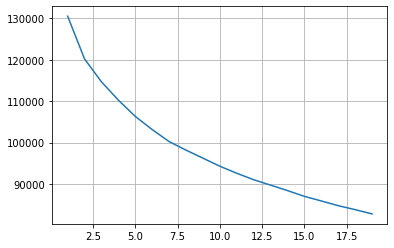

In [682]:
x_values = []
y_values = []

for i in range(1, 20):
    pipe1 = pip.Pipeline([
          ("scaler", pre.StandardScaler()),
          ("kmeans", clu.KMeans(n_clusters=i, random_state=42))
  ])
    pipe1.fit(node_embeddings.drop("node", axis=1))
    x_values.append(i)
    y_values.append(pipe1.named_steps["kmeans"].inertia_)

plt.plot(x_values, y_values)
plt.grid(True)
plt.show()

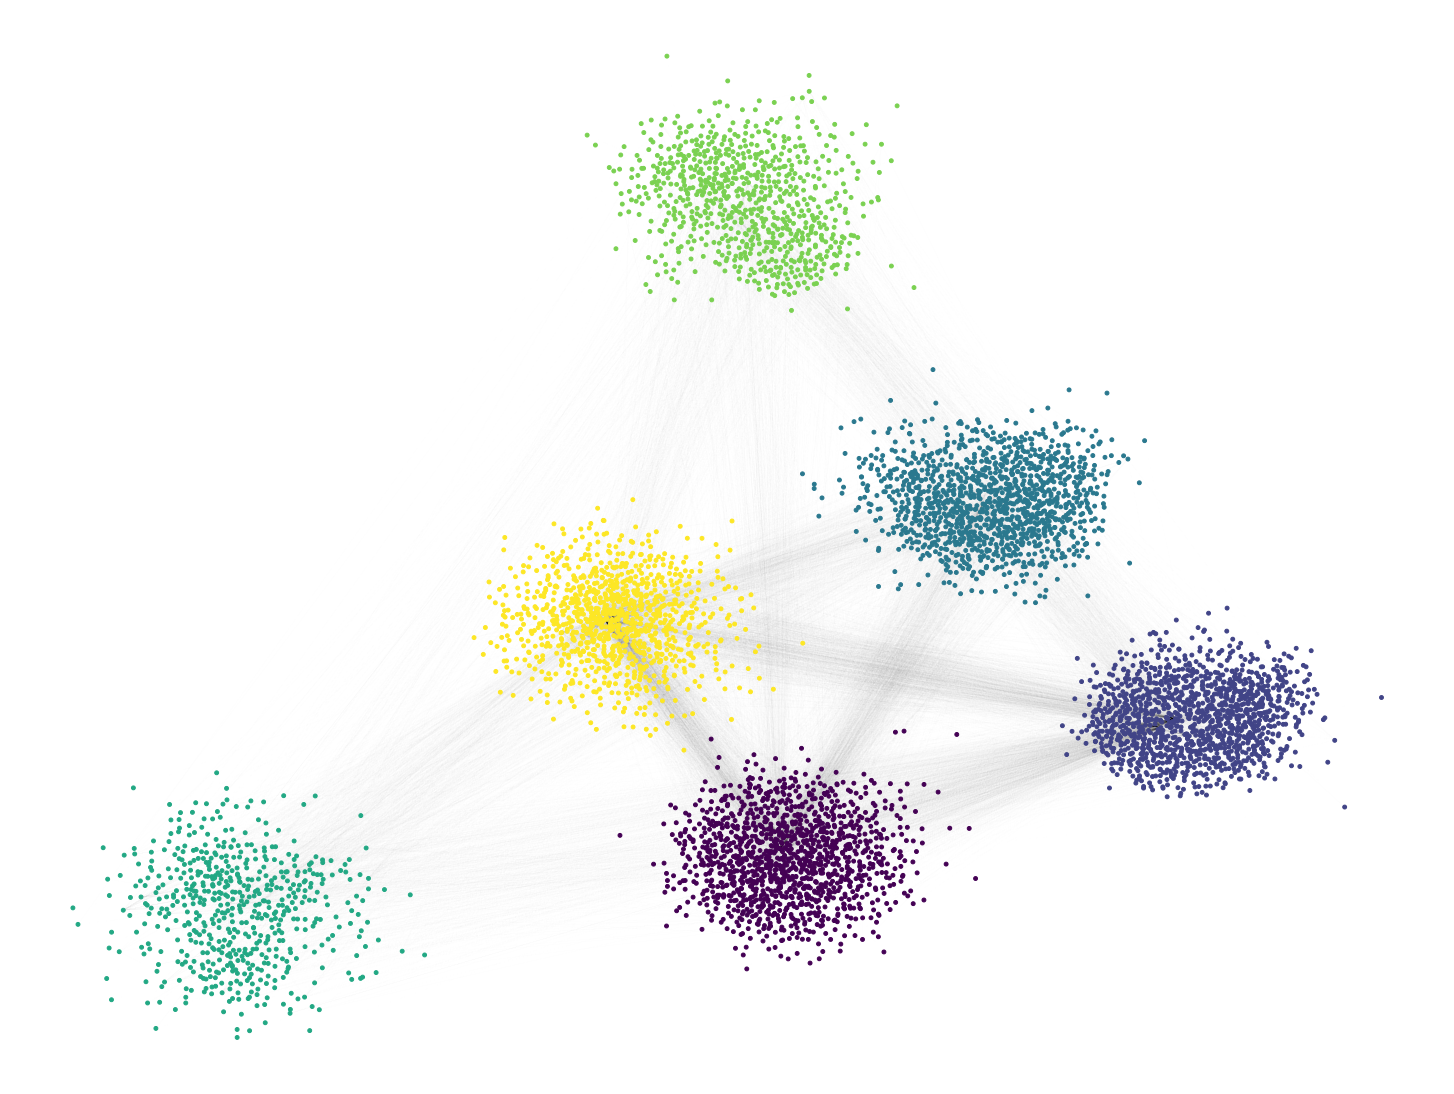

In [653]:
km = KMeans(n_clusters = 6).fit(node_embeddings.drop("node", axis=1))
partition_kmeans = dict(zip(node_embeddings["node"], km.labels_))
partition_km = {}

for key in partition:
    partition_km[key] = partition_kmeans[key]
    
visualize(G_filtered, partition_km, color_choice="auto")

In [477]:
node_embeddings["node"] = node_embeddings["node"].astype("str")

In [478]:
node_embeddings["target"] = node_embeddings["node"].map(partition)
node_embeddings.head()

,node,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,target
0,7787,-0.215202,-0.096292,-0.008538,0.173535,0.141018,0.014253,0.405446,-0.128656,0.105054,...,0.064119,0.291063,-0.241435,0.141588,0.014574,-0.109310,-0.094576,0.137296,0.172374,1
1,2684,-0.217920,-0.152467,0.129445,0.172049,0.353411,-0.206557,0.541864,-0.042081,0.065643,...,-0.051862,0.320323,-0.212720,-0.136924,0.122249,-0.241067,-0.183065,0.136005,0.268865,1
2,9206,0.025157,-0.112920,0.010243,0.154471,0.389550,-0.139871,0.479377,0.112453,0.110004,...,-0.206557,0.293745,0.064369,0.468984,-0.171380,-0.381334,-0.279143,0.248554,0.054130,5
3,1638,-0.104804,-0.013981,-0.034652,-0.239599,0.210659,0.326877,0.055464,-0.039604,0.020155,...,-0.277774,0.196116,-0.493578,0.506674,-0.115163,0.139690,0.080279,0.445901,0.115896,4
4,2914,-0.266661,-0.261977,0.018125,0.041445,0.279211,0.173043,0.493859,-0.031215,-0.036472,...,-0.133631,0.317335,-0.142674,0.208201,-0.111026,-0.143980,0.109712,0.008578,0.171912,1


In [479]:
featurelist = featurelist[["new_id", "days", "views", "mature_True"]]

In [480]:
featurelist["new_id"] = featurelist["new_id"].astype("str")

In [481]:
node_embeddings_pd = pd.merge(node_embeddings, featurelist, left_on='node', right_on='new_id', how='left').drop("new_id", axis=1)
node_embeddings_pd.head()

,node,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,target,days,views,mature_True
0,7787,-0.215202,-0.096292,-0.008538,0.173535,0.141018,0.014253,0.405446,-0.128656,0.105054,...,0.141588,0.014574,-0.109310,-0.094576,0.137296,0.172374,1,3056,54516100,0
1,2684,-0.217920,-0.152467,0.129445,0.172049,0.353411,-0.206557,0.541864,-0.042081,0.065643,...,-0.136924,0.122249,-0.241067,-0.183065,0.136005,0.268865,1,2752,16374430,1
2,9206,0.025157,-0.112920,0.010243,0.154471,0.389550,-0.139871,0.479377,0.112453,0.110004,...,0.468984,-0.171380,-0.381334,-0.279143,0.248554,0.054130,5,1884,70620803,0
3,1638,-0.104804,-0.013981,-0.034652,-0.239599,0.210659,0.326877,0.055464,-0.039604,0.020155,...,0.506674,-0.115163,0.139690,0.080279,0.445901,0.115896,4,2230,15299339,1
4,2914,-0.266661,-0.261977,0.018125,0.041445,0.279211,0.173043,0.493859,-0.031215,-0.036472,...,0.208201,-0.111026,-0.143980,0.109712,0.008578,0.171912,1,1506,2678695,0


In [482]:
X = node_embeddings_pd.drop(["node", "target"], axis=1)
y = node_embeddings_pd["target"]

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20, n_estimators=300, min_samples_leaf=2, min_samples_split=2, criterion='gini')
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(f1_score(y_test, y_pred_test, average='weighted'))
print(accuracy_score(y_test, y_pred_test))

0.8059516059740917
0.806949806949807


In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
length = int(len(X_train)*0.2)
X_val = X_train[:length]
y_val = y_train[:length]

X_train = X_train[length:]
y_train = y_train[length:]

In [485]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [397]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train_scaled.shape[1:]))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(7, activation=keras.activations.softmax))

In [664]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train_scaled.shape[1:], name="input"))
model.add(keras.layers.Dense(1000, activation="relu", name="input_layer_1"))
model.add(keras.layers.Dense(1000, activation="relu", name="input_layer_2"))
model.add(keras.layers.Dense(500, activation="relu", name="input_layer_3"))
model.add(keras.layers.Dense(6, activation=keras.activations.softmax, name="output_layer"))

In [665]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (Dense)        (None, 1000)              24000     
_________________________________________________________________
input_layer_2 (Dense)        (None, 1000)              1001000   
_________________________________________________________________
input_layer_3 (Dense)        (None, 500)               500500    
_________________________________________________________________
output_layer (Dense)         (None, 6)                 3006      
Total params: 1,528,506
Trainable params: 1,528,506
Non-trainable params: 0
_________________________________________________________________


In [430]:
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(7,'micro' or 'macro')

In [488]:
model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.sparse_categorical_crossentropy, 
              metrics=[f1])
earlyStopping_cb = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True )


In [489]:
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, verbose=1,
                    callbacks=[earlyStopping_cb], validation_data=(X_val_scaled, y_val))

Epoch 1/100
117/117 [==============================] - 6s 40ms/step - loss: 1.8079 - f1_score: 0.2711 - val_loss: 1.4518 - val_f1_score: 0.2712
Epoch 2/100
117/117 [==============================] - 4s 34ms/step - loss: 1.3334 - f1_score: 0.2709 - val_loss: 1.0392 - val_f1_score: 0.2712
Epoch 3/100
117/117 [==============================] - 4s 35ms/step - loss: 0.9665 - f1_score: 0.2707 - val_loss: 0.7840 - val_f1_score: 0.2712
Epoch 4/100
117/117 [==============================] - 4s 36ms/step - loss: 0.7252 - f1_score: 0.2709 - val_loss: 0.6625 - val_f1_score: 0.2712
Epoch 5/100
117/117 [==============================] - 4s 36ms/step - loss: 0.6257 - f1_score: 0.2709 - val_loss: 0.6012 - val_f1_score: 0.2712
Epoch 6/100
117/117 [==============================] - 4s 37ms/step - loss: 0.5513 - f1_score: 0.2710 - val_loss: 0.5680 - val_f1_score: 0.2712
Epoch 7/100
117/117 [==============================] - 4s 34ms/step - loss: 0.5211 - f1_score: 0.2710 - val_loss: 0.5543 - val_f1_score:

In [490]:
pred_train = model.predict(X_train_scaled)
print("F1 Score:",f1_score(y_train, [i.argmax() for i in pred_train], average='weighted'))
print("Accuracy:",accuracy_score(y_train, [i.argmax() for i in pred_train]))

F1 Score: 0.9204249168250982
Accuracy: 0.9203753351206434


In [491]:
pred_test = model.predict(X_test_scaled)

In [492]:
confusion_matrix(y_test, [i.argmax() for i in pred_test])

array([[117,   2,   1,   8,   9,   2],
       [  6, 301,  14,  22,   7,  18],
       [  6,  10, 195,   8,  11,  10],
       [  7,   2,   2, 291,   8,   7],
       [  6,   5,   2,  15, 283,   1],
       [  6,   8,   5,  16,   8, 135]], dtype=int64)

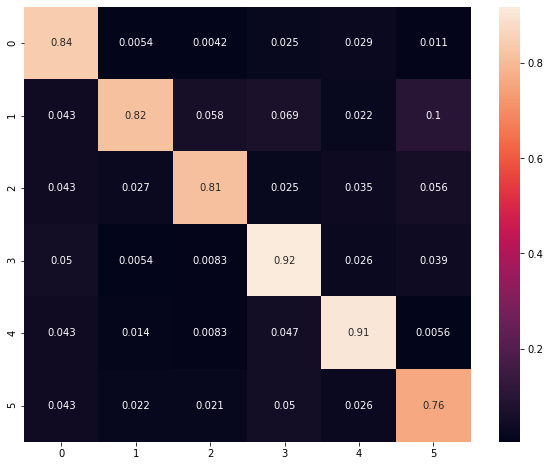

In [493]:
cm = confusion_matrix(y_test, [i.argmax() for i in pred_test])/confusion_matrix(y_test, [i.argmax() for i in pred_test]).sum(axis=1)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True);

In [494]:
print("F1 Score:",f1_score(y_test, [i.argmax() for i in pred_test], average='weighted'))
print("Accuracy:",accuracy_score(y_test, [i.argmax() for i in pred_test]))

F1 Score: 0.8505672213232278
Accuracy: 0.8507078507078507
